In [28]:
library(RCurl)
library(XML)
library(ggmap)
library(dplyr)
library(lubridate)

# Overview

NBA have 30 teams playing 82 games each during a regular season

Can we optmize the NBA and provide a better with lower distance travel?

# Data

In [79]:
calendar<-data.frame("date"=as.character(),
                     "time"=as.character(),
                     "visitor"=as.character(),
                     "visitor_pts"=as.numeric(),
                     "home"=as.character(),
                     "home_pts"=as.numeric())

### Scrapping data from Internet

Collecting the calendar from https://www.basketball-reference.com

In [80]:
months<-tolower(month.name)
years<-2016

for(j in 1:length(years)){
  
  url<-paste0("https://www.basketball-reference.com/leagues/NBA_",years[j],"_games-",months[1],".html")
  html <- xml2::read_html(url)
  node <- rvest::html_node(html, "table")
  table <- rvest::html_table(node, header = TRUE)
  table<-table[,1:6]
  
  names(table)<-c("date","time","visitor","visitor_pts","home","home_pts")
  
  for(i in 2:length(months)){
    url<-url<-paste0("https://www.basketball-reference.com/leagues/NBA_",years[j],"_games-",months[i],".html")
    if(url.exists(url)){
      html <- xml2::read_html(url)
      node <- rvest::html_node(html, "table")
      aux <- rvest::html_table(node, header = TRUE)
      aux<-aux[,1:6]
      names(aux)<-c("date","time","visitor","visitor_pts","home","home_pts")
      table<-rbind(table,aux)
    }
    else{
      next
    }
  }
  table$season<-years[j]
  calendar<-rbind(calendar,table)
}

In [97]:
calendar%>%
  filter((home=="Los Angeles Lakers" | visitor=="Los Angeles Lakers"))%>%
arrange(date2)%>%
nrow()

[1] 82

In [6]:
head(calendar)

date,time,visitor,visitor_pts,home,home_pts,season
"Fri, Jan 1, 2016",8:00 pm,New York Knicks,81,Chicago Bulls,108,2016
"Fri, Jan 1, 2016",10:30 pm,Philadelphia 76ers,84,Los Angeles Lakers,93,2016
"Fri, Jan 1, 2016",7:30 pm,Dallas Mavericks,82,Miami Heat,106,2016
"Fri, Jan 1, 2016",7:30 pm,Charlotte Hornets,94,Toronto Raptors,104,2016
"Fri, Jan 1, 2016",7:00 pm,Orlando Magic,91,Washington Wizards,103,2016
"Sat, Jan 2, 2016",3:00 pm,Brooklyn Nets,100,Boston Celtics,97,2016


### Fixing date format

In [85]:
calendar$date2<-unlist(lapply(strsplit(gsub(",","",calendar$date)," "),function(x) paste(x[2:4],collapse = "-")))
calendar$date2<-as.Date(calendar$date2,"%b-%d-%Y")
calendar<-calendar%>%
  arrange(date2)

In [90]:
calendar%>%
    filter(complete.cases(.))%>%
    group_by()%>%
    summarise(min(date2),max(date2))

min(date2),max(date2)
2015-10-27,2016-06-19


For this calendar there are playoffs games and we are not interested on playoffs once we are evaluating the distance traveled during the regular season.

The 2015-16 season ranged from 10-27-2015 to 04-13-2016 (https://en.wikipedia.org/wiki/2015%E2%80%9316_NBA_season)

### Filter Regular Season Games

In [126]:
calendar<-calendar%>%
            filter(date2<='2016-04-13')

In [127]:
# Check if every team have 82 games
sapply(unique(calendar$home),
       function(x) calendar%>%
  filter((home==x | visitor==x))%>%
  nrow())

Atlanta Hawks          Chicago Bulls  Golden State Warriors 
                    82                     82                     82 
        Boston Celtics          Brooklyn Nets        Detroit Pistons 
                    82                     82                     82 
       Houston Rockets     Los Angeles Lakers      Memphis Grizzlies 
                    82                     82                     82 
            Miami Heat        Milwaukee Bucks  Oklahoma City Thunder 
                    82                     82                     82 
         Orlando Magic           Phoenix Suns Portland Trail Blazers 
                    82                     82                     82 
      Sacramento Kings        Toronto Raptors         Indiana Pacers 
                    82                     82                     82 
  Los Angeles Clippers        New York Knicks    Cleveland Cavaliers 
                    82                     82                     82 
        Denver Nuggets     Philadelphia 76ers      San Antonio Spurs 
                    82                     82                     82 
  New Orleans Pelicans     Washington Wizards      Charlotte Hornets 
                    82                     82                     82 
Minnesota Timberwolves       Dallas Mavericks              Utah Jazz 
                    82                     82                     82

### Define Location of Games

In [93]:
calendar$home_location<-unlist(lapply(strsplit(calendar$home," "),function(x) paste(x[1:(length(x)-1)],collapse=" ")))
calendar$visitor_location<-unlist(lapply(strsplit(calendar$visitor," "),function(x) paste(x[1:(length(x)-1)],collapse=" ")))

In [95]:
unique(calendar$home_location)

[1] "Atlanta"        "Chicago"        "Golden State"   "Boston"        
 [5] "Brooklyn"       "Detroit"        "Houston"        "Los Angeles"   
 [9] "Memphis"        "Miami"          "Milwaukee"      "Oklahoma City" 
[13] "Orlando"        "Phoenix"        "Portland Trail" "Sacramento"    
[17] "Toronto"        "Indiana"        "New York"       "Cleveland"     
[21] "Denver"         "Philadelphia"   "San Antonio"    "New Orleans"   
[25] "Washington"     "Charlotte"      "Minnesota"      "Dallas"        
[29] "Utah"

Based on the name of the home team we can identify the game location. For example, when the home team is 'Chicago Bulls' we know the game was hosted in Chicago.

In a simple example, for a match between 'Chicago Bulls' and 'Memphis Grizzles' where the home team is 'Chicago Bulls' we assume that there was travel from Memphis to Chicago.

Even though the home_location was able to identify the location of games we still had to do some manual adjustments. For example, Golden State -> San Franciso

In [142]:
calendar$home_location[calendar$home_location=="Portland Trail"]<-"Portland"
calendar$home_location[calendar$home_location=="Utah"]<-"Salt Lake City"
calendar$home_location[calendar$home_location=="Indiana"]<-"Indianapolis"
calendar$home_location[calendar$home_location=="Minnesota"]<-"Minneapolis"
calendar$home_location[calendar$home_location=="Golden State"]<-"San Francisco"
calendar$home_location[calendar$home_location=="Washington"]<-"Washington D.C."

### Latitude and Longitude for the Cities where the Teams are located

In [43]:
cities<-unique(calendar$home_location)
pos<-geocode(cities)
citiesLocation<-data.frame(cities,pos)

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Atlanta&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Chicago&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San+Francisco&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Boston&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Brooklyn&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Detroit&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Houston&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Los+Angeles&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Memphis&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=M

In [44]:
head(citiesLocation)

cities,lon,lat
Atlanta,-84.38798,33.74900
Chicago,-87.62980,41.87811
San Francisco,-122.41942,37.77493
Boston,-71.05888,42.36008
Brooklyn,-73.94416,40.67818
Detroit,-83.04575,42.33143


### Calculate the Distance between Teams based on Latitude and Longitude

In [40]:
# Function to calculate distance in kilometers between two points
# reference: http://andrew.hedges.name/experiments/haversine/
earth.dist <- function (lon1, lat1, lon2, lat2, R)
{
  rad <- pi/180
  a1 <- lat1 * rad
  a2 <- lon1 * rad
  b1 <- lat2 * rad
  b2 <- lon2 * rad
  dlon <- b2 - a2
  dlat <- b1 - a1
  a <- (sin(dlat/2))^2 + cos(a1) * cos(b1) * (sin(dlon/2))^2
  c <- 2 * atan2(sqrt(a), sqrt(1 - a))
  d <- R * c
  real.d <- min(abs((R*2) - d), d)
  return(real.d)
}

In [53]:
distance<-expand.grid(unique(calendar$home_location),unique(calendar$home_location))
names(distance)<-c("team1","team2")

distance<-merge(x=distance,
                y=citiesLocation,
                by.x="team1",
                by.y="cities",
                all.x=TRUE)
names(distance)[3:4]<-c("lon1","lat1")

distance<-merge(x=distance,
                y=citiesLocation,
                by.x="team2",
                by.y="cities",
                all.x=TRUE)
names(distance)[5:6]<-c("lon2","lat2")

All Combinations

In [98]:
head(distance)

team2,team1,lon1,lat1,lon2,lat2,distanceKM
Atlanta,Atlanta,-84.38798,33.74900,-84.38798,33.749,0.000
Atlanta,New York,-74.00594,40.71278,-84.38798,33.749,1201.665
Atlanta,Phoenix,-112.07404,33.44838,-84.38798,33.749,2559.549
Atlanta,Denver,-104.99025,39.73924,-84.38798,33.749,1949.539
Atlanta,San Antonio,-98.49363,29.42412,-84.38798,33.749,1420.095
Atlanta,Milwaukee,-87.90647,43.03890,-84.38798,33.749,1078.468


In [55]:
result<-rep(NA,nrow(distance))
for(i in 1:nrow(distance)){
  result[i]<-earth.dist(distance$lon1[i],distance$lat1[i],distance$lon2[i],distance$lat2[i],R=6378.145)
}
distance$distanceKM<-result

In [57]:
head(distance)

team2,team1,lon1,lat1,lon2,lat2,distanceKM
Atlanta,Atlanta,-84.38798,33.74900,-84.38798,33.749,0.000
Atlanta,New York,-74.00594,40.71278,-84.38798,33.749,1201.665
Atlanta,Phoenix,-112.07404,33.44838,-84.38798,33.749,2559.549
Atlanta,Denver,-104.99025,39.73924,-84.38798,33.749,1949.539
Atlanta,San Antonio,-98.49363,29.42412,-84.38798,33.749,1420.095
Atlanta,Milwaukee,-87.90647,43.03890,-84.38798,33.749,1078.468


### Function to calculate Distance traveled by a Team during the season

This function returns a data frame with flights for a specific team during the season

In [115]:
nbaFlightsByTeam<-function(base,team){
  aux<-base%>%
    filter((home==team | visitor==team))%>%
    arrange(date2)
  
  initial = names(tail(sort(table(aux$home_location)),1))
  
  flight_from = c(initial,rep(NA,nrow(aux)-1))
  flight_to = c(rep(NA,(nrow(aux)-1)),initial)
  d = rep(NA,nrow(aux))
  
  for(i in 1:(nrow(aux)-1)){
    flight_to[i] = aux$home_location[i]
    flight_from[i+1] = flight_to[i]
    d[i] = distance$distance[which(distance$team1==flight_from[i] & distance$team2==flight_to[i])]
  }
  d[nrow(aux)] = distance$distance[which(distance$team1==flight_from[nrow(aux)] & distance$team2==flight_to[nrow(aux)])]
  return(data.frame(flight_from,flight_to,"distance"=d))
}

In [100]:
PHI_flights<-nbaFlightsByTeam(calendar,"Philadelphia 76ers")

In [101]:
head(PHI_flights)

flight_from,flight_to,distance
Philadelphia,Boston,436.1181
Boston,Philadelphia,436.1181
Philadelphia,Philadelphia,0.0000
Philadelphia,Milwaukee,1115.2003
Milwaukee,Cleveland,539.5069
Cleveland,Philadelphia,576.9254


To get the total kilometers traveled by the Philadelphia 76ers during the 2015-16 regular season we just have to sum the variable distance.

In [108]:
sum(PHI_flights$distance) #75620.3841074576

[1] 75620.38

In [109]:
lal<-nbaFlightsByTeam(calendar,"Los Angeles Lakers")

In [111]:
sum(lal$distance) #78106.9400997549

[1] 78106.94

In [125]:
sum(nbaFlightsByTeam(calendar,"Miami Heat")$distance)

[1] 90774.72

In [113]:
teams <- unique(calendar$home)

[1] "Atlanta Hawks"          "Chicago Bulls"          "Golden State Warriors" 
 [4] "Boston Celtics"         "Brooklyn Nets"          "Detroit Pistons"       
 [7] "Houston Rockets"        "Los Angeles Lakers"     "Memphis Grizzlies"     
[10] "Miami Heat"             "Milwaukee Bucks"        "Oklahoma City Thunder" 
[13] "Orlando Magic"          "Phoenix Suns"           "Portland Trail Blazers"
[16] "Sacramento Kings"       "Toronto Raptors"        "Indiana Pacers"        
[19] "Los Angeles Clippers"   "New York Knicks"        "Cleveland Cavaliers"   
[22] "Denver Nuggets"         "Philadelphia 76ers"     "San Antonio Spurs"     
[25] "New Orleans Pelicans"   "Washington Wizards"     "Charlotte Hornets"     
[28] "Minnesota Timberwolves" "Dallas Mavericks"       "Utah Jazz"

In [122]:
total_distance_by_team<-sapply(teams,function(x) sum(nbaFlightsByTeam(calendar,x)$distance))

In [123]:
total_distance_by_team[order(total_distance_by_team,decreasing=TRUE)]

Washington Wizards             Miami Heat         Boston Celtics 
             162390.79               90774.72               89905.20 
         Orlando Magic  Golden State Warriors Minnesota Timberwolves 
              88898.89               87413.02               86649.36 
     San Antonio Spurs Portland Trail Blazers        Houston Rockets 
              84908.78               84162.64               82513.96 
      Sacramento Kings      Memphis Grizzlies           Phoenix Suns 
              81895.35               80901.26               79741.69 
      Dallas Mavericks     Los Angeles Lakers  Oklahoma City Thunder 
              78689.61               78106.94               78004.53 
  New Orleans Pelicans              Utah Jazz     Philadelphia 76ers 
              77235.05               76250.56               75620.38 
  Los Angeles Clippers          Atlanta Hawks         Denver Nuggets 
              75281.22               74646.74               74320.82 
     Charlotte Hornets        New York Knicks          Chicago Bulls 
              74156.58               73635.43               71553.15 
       Toronto Raptors        Milwaukee Bucks          Brooklyn Nets 
              71370.75               71173.31               69089.23 
       Detroit Pistons         Indiana Pacers    Cleveland Cavaliers 
              68647.70               66332.25               65417.60

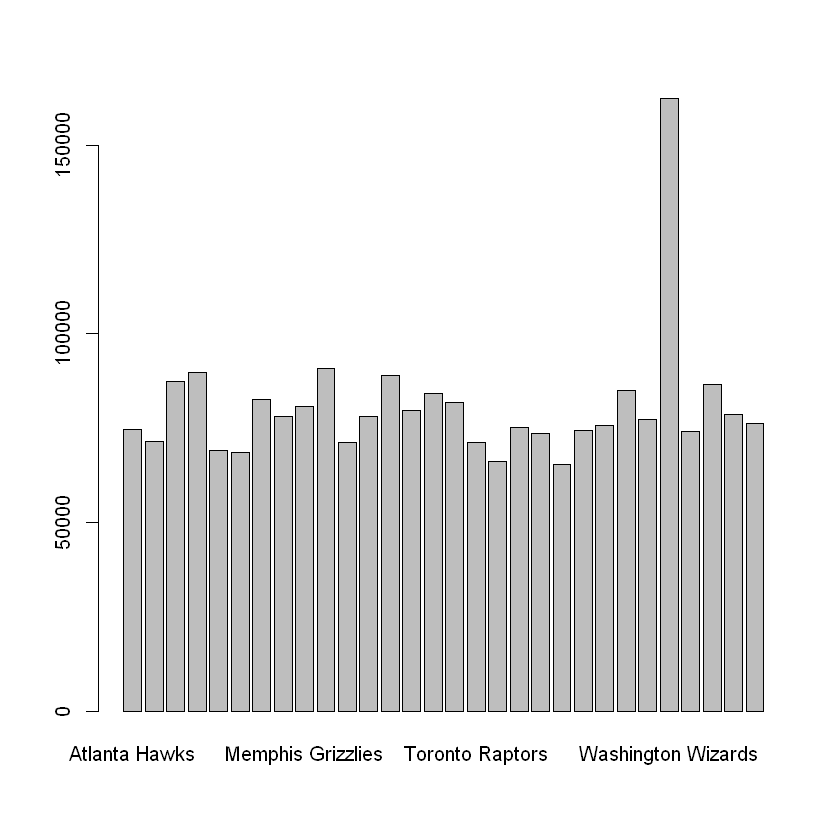

In [141]:
barplot(total_distance_by_team)

In [2]:
library(plotly)
set.seed(100)
d <- diamonds[sample(nrow(diamonds), 1000), ]
myPlot <- plot_ly(d, x = carat, y = price, text = paste("Clarity: ", clarity),
        mode = "markers", color = carat, size = carat)
embed_notebook(myPlot)